# Python資料分析與機器學習應用 Final Project

In [2]:
!pip install selenium

  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached trio-0.30.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached trio_websocket-0.12.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached outcome-1.3.0.post0-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 35.3 MB/s eta 0:00:00a 0:00:01
Using cached certifi-2025.4.26-py3-none-any.whl (159 kB)
Using cached trio-0.30.0-py3-none-any.whl (499 kB)
Using cached trio_websocket-0.12.2-py3-none-any.whl (21 kB)
Usin

In [3]:
import os
import time
import csv
import pickle
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

# ========== Step 1: 設定 Chrome WebDriver ==========
webdriver_path = "/opt/homebrew/bin/chromedriver"
service = Service(webdriver_path)
options = Options()
# options.add_argument('--headless')  # 若需背景執行可取消註解
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--disable-infobars")
options.add_argument("--start-maximized")
options.add_argument("--disable-extensions")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36")

driver = webdriver.Chrome(service=service, options=options)

# ========== Step 2: Cookies 自動登入邏輯 ==========
COOKIES_FILE = "twitter_cookies.pkl"

def save_cookies():
    with open(COOKIES_FILE, "wb") as f:
        pickle.dump(driver.get_cookies(), f)

def load_cookies():
    if not os.path.exists(COOKIES_FILE):
        return False
    driver.get("https://x.com")
    with open(COOKIES_FILE, "rb") as f:
        cookies = pickle.load(f)
    for cookie in cookies:
        if "expiry" in cookie:
            del cookie["expiry"]
        driver.add_cookie(cookie)
    driver.refresh()
    return True

def login_and_save():
    driver.get("https://x.com/login")
    print("🔐 請手動登入 Twitter（輸入帳號、密碼、驗證碼）...")
    input("👉 登入成功後，請回到終端機按下 Enter 鍵儲存 cookie：")
    save_cookies()
    print("✅ Cookies 已儲存，下次將自動登入")

if not load_cookies():
    login_and_save()
else:
    print("✅ Cookies 已載入，自動登入成功")

# ========== Step 3: 抓取特定日期的推文 ==========
# 修改這裡的日期範圍
since = "2025-05-09"
until = "2025-05-10"
target_url = f"https://x.com/search?q=tariff%20until%3A{until}%20since%3A{since}&src=typed_query"
driver.get(target_url)
time.sleep(5)

# ========== Step 4: 滾動並擷取推文 ==========
scroll_pause_time = 3
all_tweet_data = []
processed_tweets = set()
count = -1

while len(processed_tweets) != count:
    count = len(processed_tweets)
    try:
        article_elements = driver.find_elements(By.XPATH, '//article[@data-testid="tweet"]')
    except:
        break
    if not article_elements:
        print("❗ 沒有找到更多推文，停止抓取")
        break

    for article in article_elements:
        try:
            tweet_text_element = article.find_element(By.XPATH, './/div[@data-testid="tweetText"]')
            tweet_text = tweet_text_element.text
            if tweet_text in processed_tweets:
                continue
            processed_tweets.add(tweet_text)

            time_element = article.find_element(By.XPATH, './/a/time')
            timestamp_str = time_element.get_attribute('datetime')

            all_tweet_data.append({
                'Timestamp': timestamp_str,
                'Tweet Content': tweet_text,
            })

        except Exception as e:
            print(f"⚠️ 抓取推文時發生錯誤: {e}")
            continue

    driver.execute_script("window.scrollBy(0, 3000);")
    time.sleep(scroll_pause_time)

# ========== Step 5: 儲存至 CSV ==========
date_str = since
csv_file_path = f'tariff_data{date_str.replace("-", "")}.csv'

try:
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Timestamp', 'Tweet Content']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for data in all_tweet_data:
            writer.writerow(data)
    print(f"📁 已儲存推文至：{csv_file_path}（共 {len(all_tweet_data)} 則）")
except Exception as e:
    print(f"❌ 儲存失敗：{e}")

# ========== Step 6: 關閉瀏覽器 ==========
driver.quit()


## Data Analysis

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# === 設定資料夾 ===
data_folder = "data/tariff_data_en"  # <-- 改成你的資料夾名稱
analyzer = SentimentIntensityAnalyzer()
sentiment_map = {"negative": 0, "neutral": 1, "positive": 2}

# === 定義特徵萃取函數 ===
def extract_day_features(df, date_str):
    df = df.copy()
    df["sentiment_score"] = df["sentiment"].map(sentiment_map)
    df["length"] = df["Tweet Content"].astype(str).apply(len)
    df["num_words"] = df["Tweet Content"].astype(str).apply(lambda x: len(x.split()))
    df["num_hashtags"] = df["Tweet Content"].astype(str).str.count("#")
    df["num_mentions"] = df["Tweet Content"].astype(str).str.count("@")
    df["uppercase_ratio"] = df["Tweet Content"].astype(str).apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    df["vader_compound"] = df["Tweet Content"].astype(str).apply(
        lambda x: analyzer.polarity_scores(x)["compound"])

    total = len(df)
    return {
        "date": date_str,
        "num_tweets": total,
        "avg_length": df["length"].mean(),
        "avg_num_words": df["num_words"].mean(),
        "avg_hashtags": df["num_hashtags"].mean(),
        "avg_mentions": df["num_mentions"].mean(),
        "avg_uppercase_ratio": df["uppercase_ratio"].mean(),
        "prop_negative": len(df[df["sentiment"] == "negative"]) / total if total else 0,
        "prop_neutral": len(df[df["sentiment"] == "neutral"]) / total if total else 0,
        "prop_positive": len(df[df["sentiment"] == "positive"]) / total if total else 0,
        "vader_avg_compound": df["vader_compound"].mean(),
        "vader_std_compound": df["vader_compound"].std(),
        "vader_max_compound": df["vader_compound"].max(),
        "vader_min_compound": df["vader_compound"].min(),
        "avg_sentiment_score": df["sentiment_score"].mean(),
        "day_of_week": datetime.strptime(date_str, "%Y-%m-%d").weekday(),
        "is_weekend": 1 if datetime.strptime(date_str, "%Y-%m-%d").weekday() >= 5 else 0
    }

# === 讀取所有 CSV 並處理 ===
feature_rows = []
for filename in sorted(os.listdir(data_folder)):
    if filename.endswith(".csv"):
        filepath = os.path.join(data_folder, filename)
        try:
            df = pd.read_csv(filepath)
            # 推論日期
            date_str = filename.replace("tariff_data_", "").replace(".csv", "")
            if "-" not in date_str:  # 像 20250403
                date_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
            features = extract_day_features(df, date_str)
            feature_rows.append(features)
        except Exception as e:
            print(f"❌ Error reading {filename}: {e}")

# === 建立結果 DataFrame ===
features_df = pd.DataFrame(feature_rows)
print("✅ 萃取完成，以下是特徵預覽：")
print(features_df.head())

# === 可選：儲存為 CSV ===
features_df.to_csv("daily_sentiment_features.csv", index=False)


✅ 萃取完成，以下是特徵預覽：
         date  num_tweets  avg_length  avg_num_words  avg_hashtags  \
0  2025-03-01          57  186.807018      27.807018      0.526316   
1  2025-03-02         150  183.986667      27.406667      0.386667   
2  2025-03-03         205  163.819512      25.600000      0.165854   
3  2025-03-04         215  178.246512      27.265116      0.344186   
4  2025-03-05         216  172.273148      26.629630      0.435185   

   avg_mentions  avg_uppercase_ratio  prop_negative  prop_neutral  \
0      0.157895             0.061645       0.614035      0.157895   
1      0.153333             0.072549       0.546667      0.173333   
2      0.112195             0.067358       0.478049      0.234146   
3      0.162791             0.066337       0.460465      0.167442   
4      0.236111             0.061758       0.393519      0.324074   

   prop_positive  vader_avg_compound  vader_std_compound  vader_max_compound  \
0       0.228070           -0.200100            0.484145            

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("daily_sentiment_features.csv")
df = df.dropna()
df.head()

,date,num_tweets,avg_length,avg_num_words,avg_hashtags,avg_mentions,avg_uppercase_ratio,prop_negative,prop_neutral,prop_positive,vader_avg_compound,vader_std_compound,vader_max_compound,vader_min_compound,avg_sentiment_score,day_of_week,is_weekend
0,2025-03-01,57,186.807018,27.807018,0.526316,0.157895,0.061645,0.614035,0.157895,0.228070,-0.200100,0.484145,0.9309,-0.8519,0.614035,5,1
1,2025-03-02,150,183.986667,27.406667,0.386667,0.153333,0.072549,0.546667,0.173333,0.280000,-0.190273,0.445028,0.8122,-0.9300,0.733333,6,1
2,2025-03-03,205,163.819512,25.600000,0.165854,0.112195,0.067358,0.478049,0.234146,0.287805,-0.117938,0.429847,0.8625,-0.9201,0.809756,0,0
3,2025-03-04,215,178.246512,27.265116,0.344186,0.162791,0.066337,0.460465,0.167442,0.372093,-0.031871,0.534663,0.9081,-0.9622,0.911628,1,0
4,2025-03-05,216,172.273148,26.629630,0.435185,0.236111,0.061758,0.393519,0.324074,0.282407,-0.107240,0.473492,0.8834,-0.9590,0.888889,2,0


In [4]:
# 將日期轉為 datetime 格式並設為索引
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 排除非數值型欄位（已排除 'date'）
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

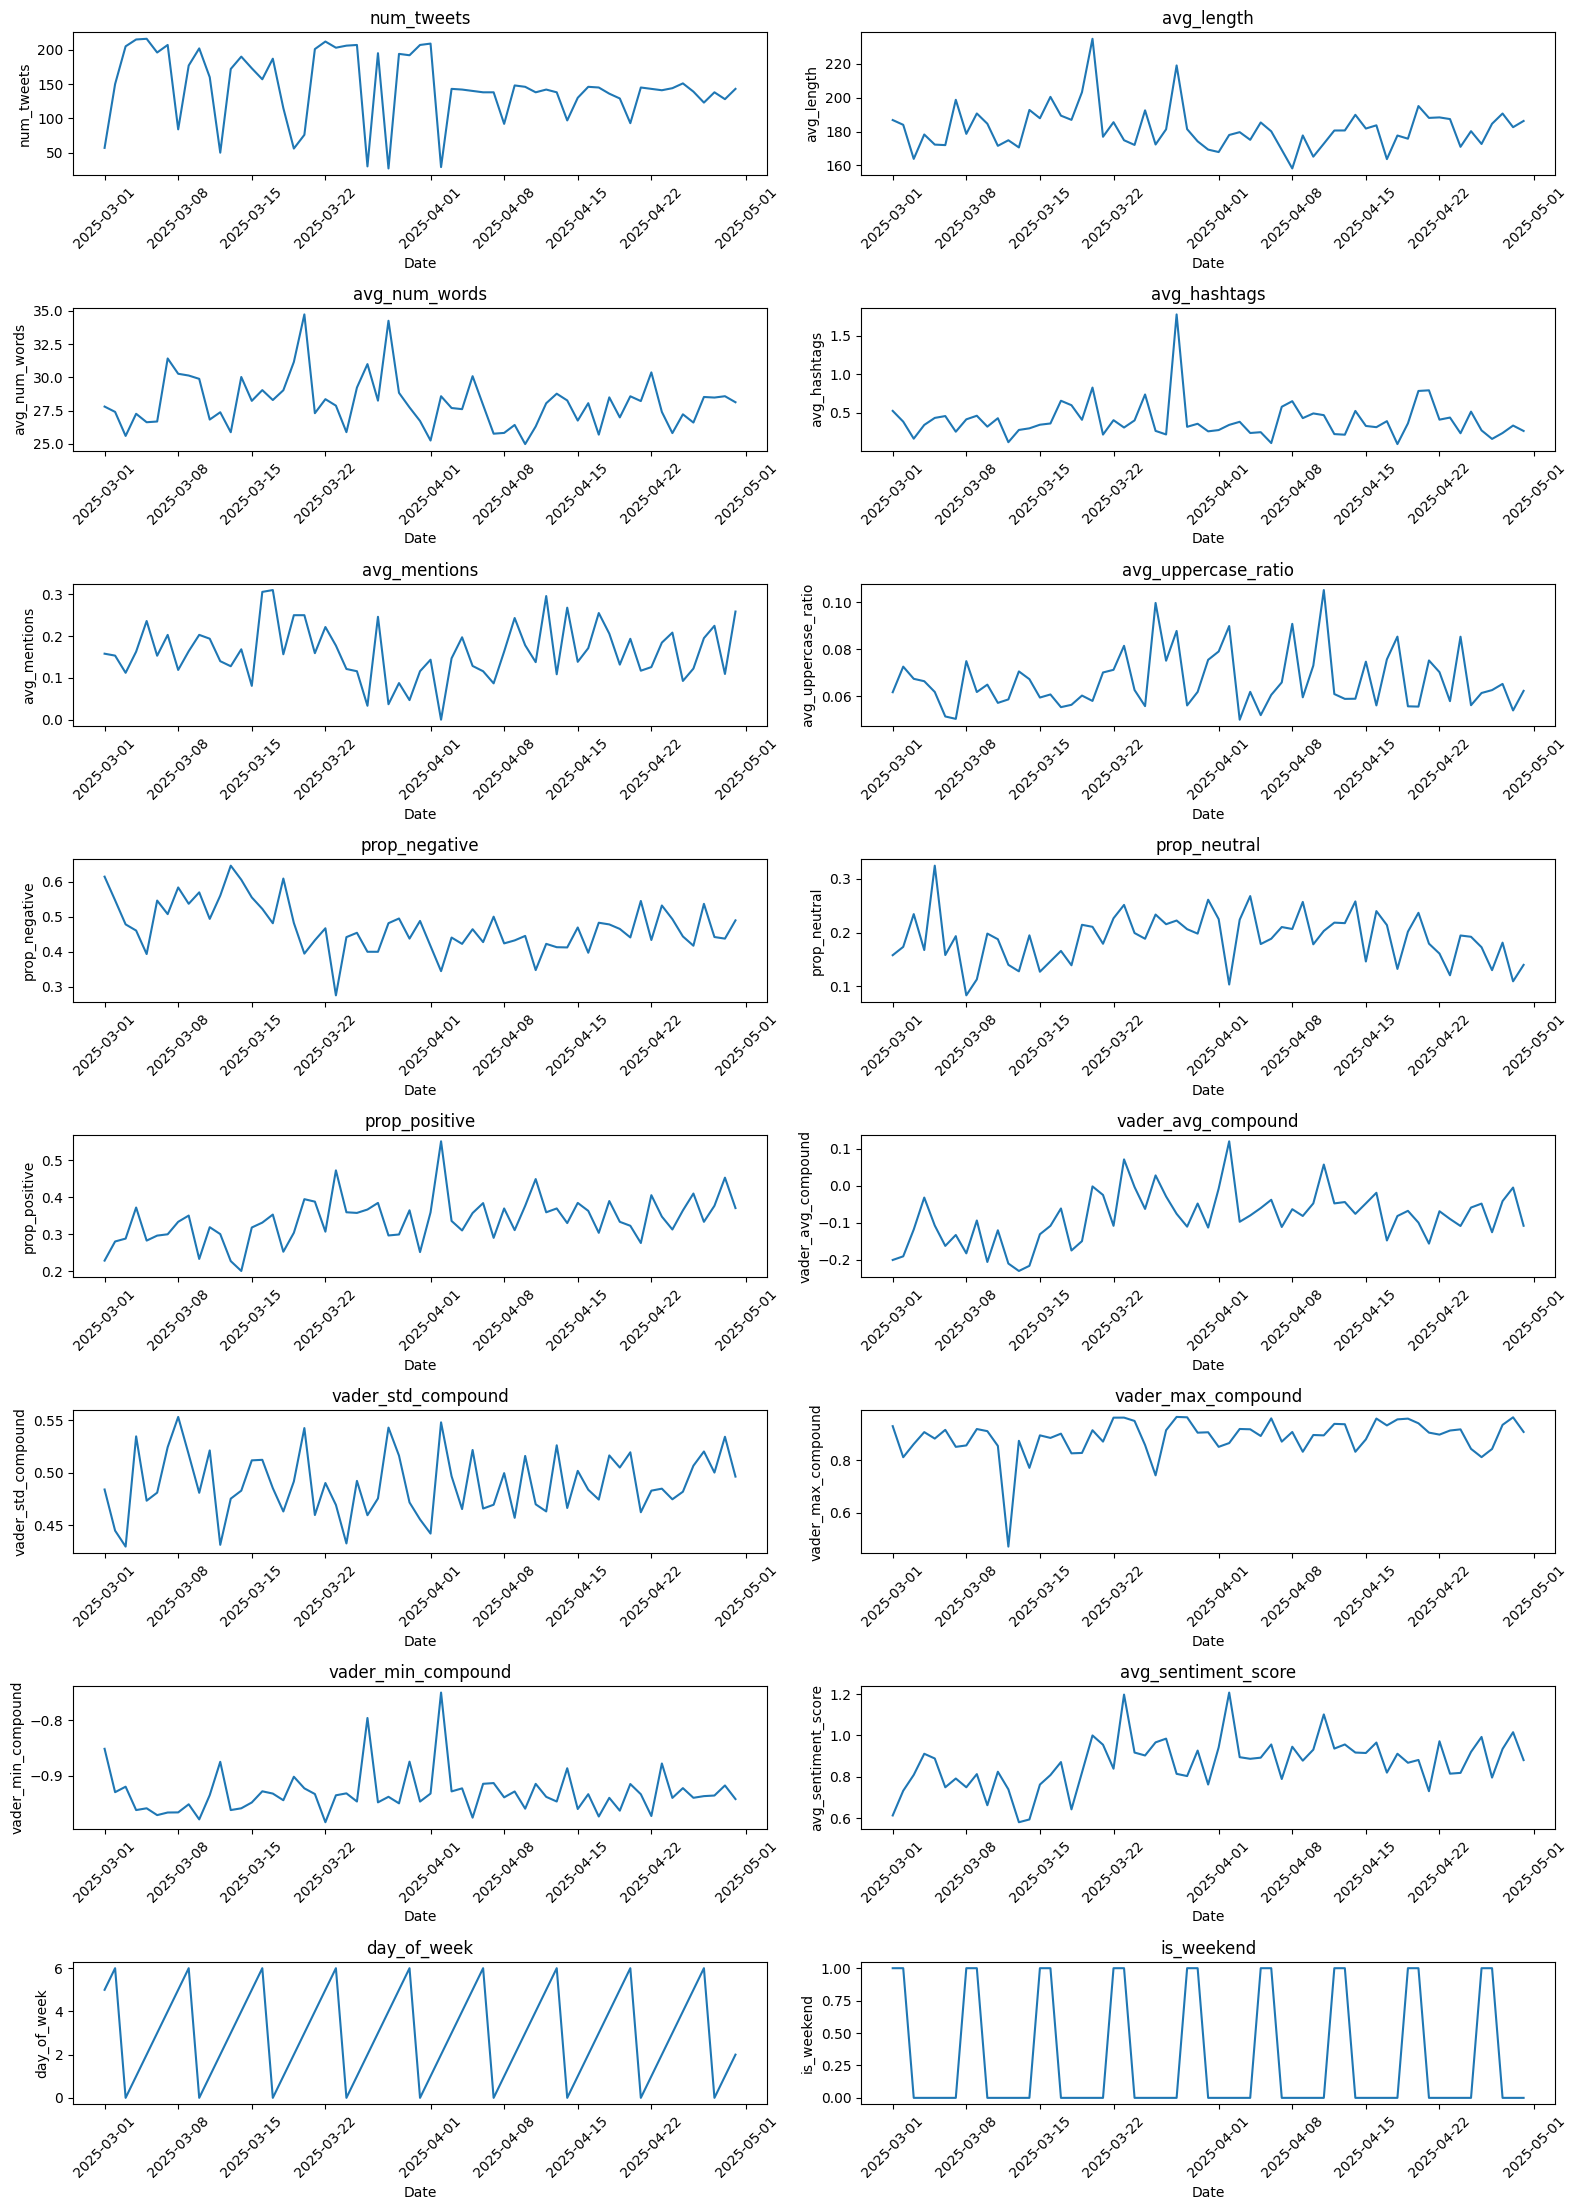

In [5]:
# 繪圖設定
plt.figure(figsize=(16, 24))
for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns)//2 + 1, 2, i + 1)
    sns.lineplot(data=df, x=df.index, y=column)
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [6]:
df = pd.read_csv("daily_sentiment_features.csv")
df = df.dropna()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 排除非數值型欄位（已排除 'date'）
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df.head()

,num_tweets,avg_length,avg_num_words,avg_hashtags,avg_mentions,avg_uppercase_ratio,prop_negative,prop_neutral,prop_positive,vader_avg_compound,vader_std_compound,vader_max_compound,vader_min_compound,avg_sentiment_score,day_of_week,is_weekend
date,,,,,,,,,,,,,,,,
2025-03-01,57,186.807018,27.807018,0.526316,0.157895,0.061645,0.614035,0.157895,0.228070,-0.200100,0.484145,0.9309,-0.8519,0.614035,5,1
2025-03-02,150,183.986667,27.406667,0.386667,0.153333,0.072549,0.546667,0.173333,0.280000,-0.190273,0.445028,0.8122,-0.9300,0.733333,6,1
2025-03-03,205,163.819512,25.600000,0.165854,0.112195,0.067358,0.478049,0.234146,0.287805,-0.117938,0.429847,0.8625,-0.9201,0.809756,0,0
2025-03-04,215,178.246512,27.265116,0.344186,0.162791,0.066337,0.460465,0.167442,0.372093,-0.031871,0.534663,0.9081,-0.9622,0.911628,1,0
2025-03-05,216,172.273148,26.629630,0.435185,0.236111,0.061758,0.393519,0.324074,0.282407,-0.107240,0.473492,0.8834,-0.9590,0.888889,2,0


In [7]:
for i in range(1, 5): # 生成 lag1, lag2, lag3, lag4
    df[f'lag_{i}'] = df['vader_avg_compound'].shift(i)

In [8]:
df_cleaned = df.dropna()
len(df)

61

In [10]:
import warnings
warnings.filterwarnings("ignore")



模型性能評估 (測試集):
均方根誤差 (RMSE): 0.0310
R-squared (R²): 0.3854


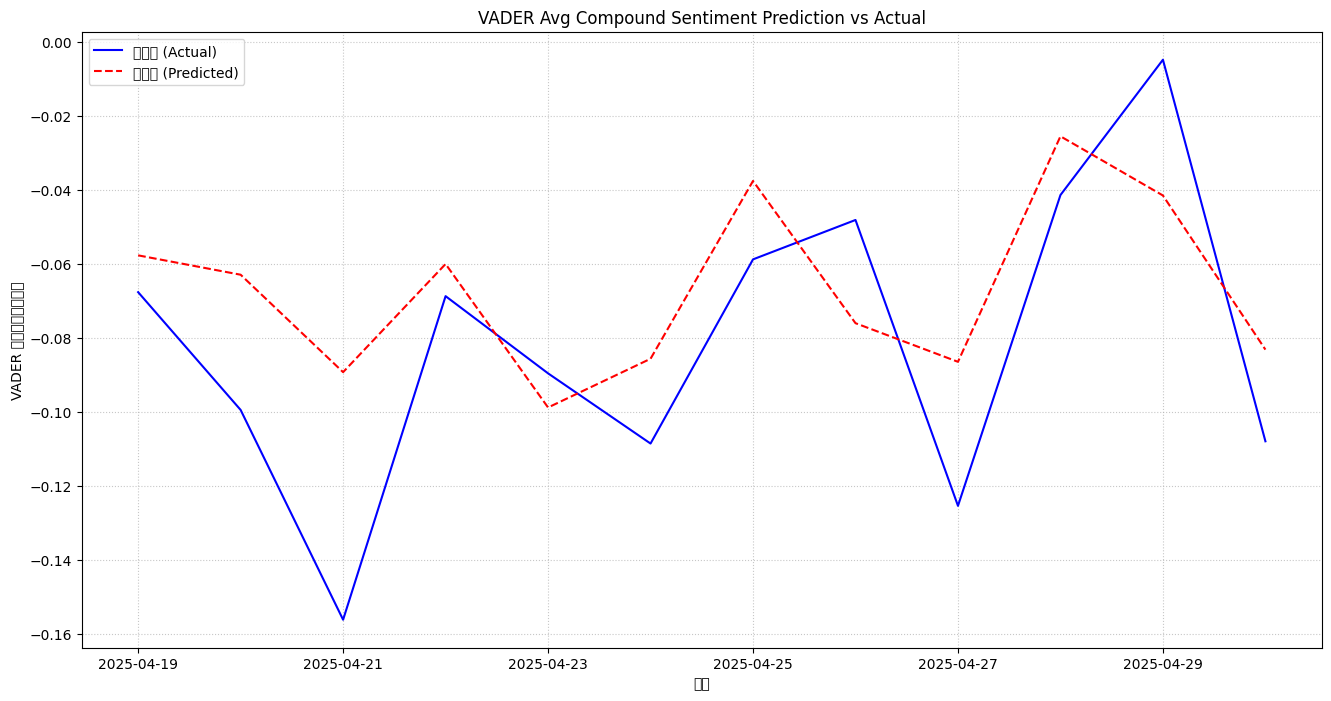


特徵重要性:
  Feature  Importance
3   lag_4    0.304545
2   lag_3    0.302688
0   lag_1    0.228554
1   lag_2    0.164214


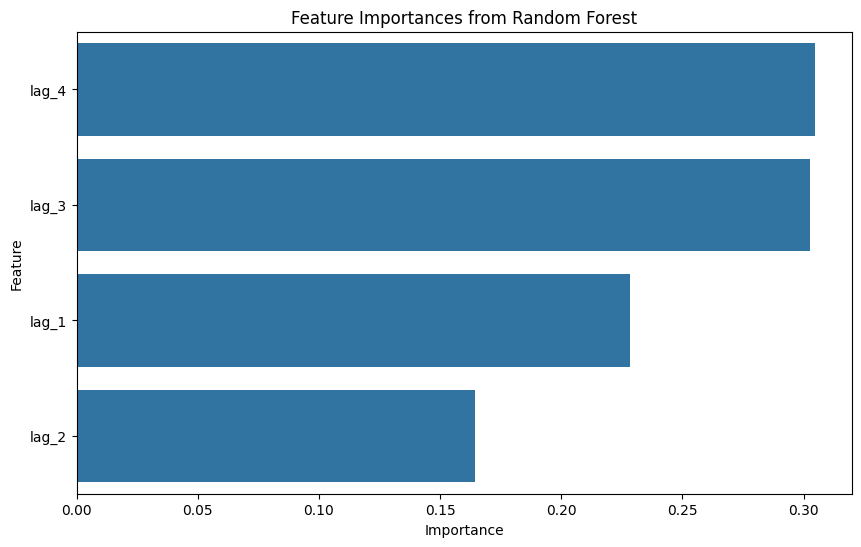

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # 雖然用這個函數，但實際是手動分割
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

train_size = int(len(df_cleaned) * 0.8)
train_df = df_cleaned.iloc[:train_size]
test_df = df_cleaned.iloc[train_size:]

# 定義特徵 (X) 和目標 (y)
features = [f'lag_{i}' for i in range(1, 5)] # 我們的特徵就是 lag1, lag2, lag3, lag4
target = 'vader_avg_compound'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]


# === 5. 模型訓練：使用 RandomForestRegressor ===
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
model.fit(X_train, y_train)

# === 6. 模型預測與評估 ===
y_pred = model.predict(X_test)

# 計算性能指標
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n模型性能評估 (測試集):")
print(f"均方根誤差 (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# === 7. 視覺化預測結果 (可選) ===
plt.figure(figsize=(16, 8))
plt.plot(y_test.index, y_test, label='實際值 (Actual)', color='blue')
plt.plot(y_test.index, y_pred, label='預測值 (Predicted)', color='red', linestyle='--')
plt.title('VADER Avg Compound Sentiment Prediction vs Actual')
plt.xlabel('日期')
plt.ylabel('VADER 平均複合情感分數')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
# plt.tight_layout()
plt.show()

# 顯示特徵重要性 (Feature Importance)
# 可以幫助你了解哪個 lag feature 對預測最重要
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print("\n特徵重要性:")
    print(importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importances from Random Forest')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    # plt.tight_layout()
    plt.show()

In [12]:
df.columns

Index(['num_tweets', 'avg_length', 'avg_num_words', 'avg_hashtags',
       'avg_mentions', 'avg_uppercase_ratio', 'prop_negative', 'prop_neutral',
       'prop_positive', 'vader_avg_compound', 'vader_std_compound',
       'vader_max_compound', 'vader_min_compound', 'avg_sentiment_score',
       'day_of_week', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 'lag_4'],
      dtype='object')

In [13]:
from sklearn.preprocessing import MinMaxScaler
df['vader_avg_compound_scaled'] = MinMaxScaler().fit_transform(df[['vader_avg_compound']])
df['vader_std_compound_scaled'] = MinMaxScaler().fit_transform(df[['vader_std_compound']])
df['prop_negative_scaled'] = MinMaxScaler().fit_transform(df[['prop_negative']])
df['prop_positive_scaled'] = MinMaxScaler().fit_transform(df[['prop_positive']])

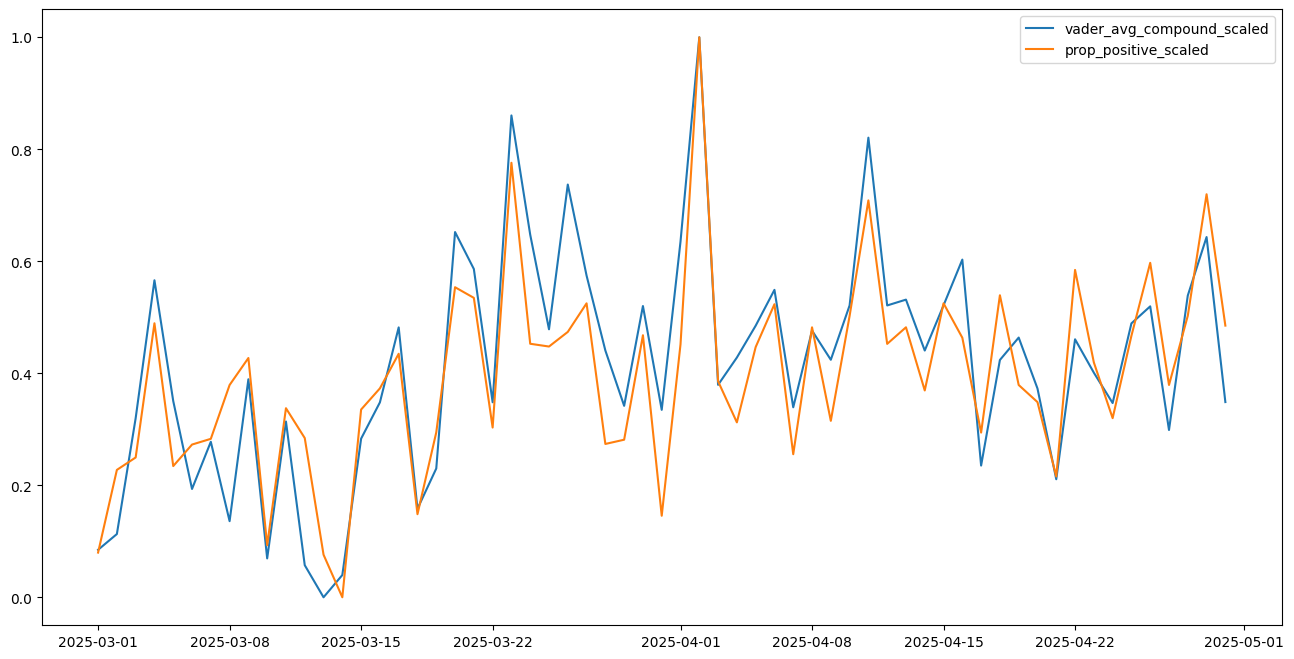

In [14]:
columns=[
'vader_avg_compound_scaled',
'prop_positive_scaled'
]
plt.figure(figsize=(16, 8))
for column in columns:
    plt.plot(df[column],label=column)
plt.legend()

Text(0, 0.5, 'VADER Avg Compound Sentiment Score')

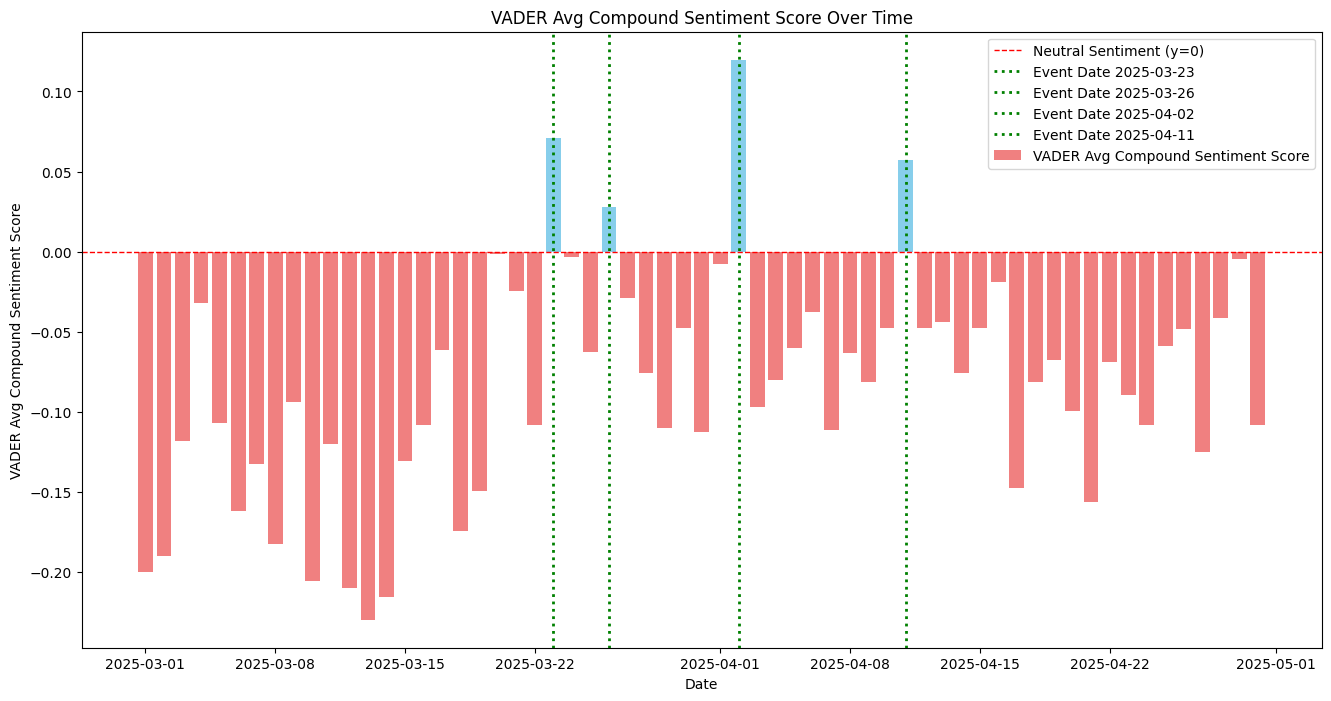

In [15]:
plt.figure(figsize=(16, 8))
# plt.bar(df.index,df['vader_avg_compound'])
plt.bar(df.index, df['vader_avg_compound'], width=0.8, label='VADER Avg Compound Sentiment Score',
        color=['skyblue' if x >= 0 else 'lightcoral' for x in df['vader_avg_compound']]) # Optional: color based on positive/negative
plt.axhline(y=0, color='r', linestyle='--', linewidth=1, label='Neutral Sentiment (y=0)')
event_date = pd.to_datetime('2025-03-23')
plt.axvline(x=event_date, color='green', linestyle=':', linewidth=2, label='Event Date 2025-03-23')
event_date = pd.to_datetime('2025-03-26')
plt.axvline(x=event_date, color='green', linestyle=':', linewidth=2, label='Event Date 2025-03-26')
event_date = pd.to_datetime('2025-04-02')
plt.axvline(x=event_date, color='green', linestyle=':', linewidth=2, label='Event Date 2025-04-02')
event_date = pd.to_datetime('2025-04-11')
plt.axvline(x=event_date, color='green', linestyle=':', linewidth=2, label='Event Date 2025-04-11')
plt.legend()
plt.title('VADER Avg Compound Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('VADER Avg Compound Sentiment Score')

In [16]:
import os
import pandas as pd

# === 設定你的資料夾路徑 ===
# 請將這裡替換為你實際的 CSV 檔案所在的資料夾路徑
folder_path = "data/tariff_data_en"  # 例如: "data/raw_csvs"

# === 1. 建立一個空列表來存放每個 CSV 檔的 DataFrame ===
all_dataframes = []

# === 2. 遍歷資料夾中的所有檔案 ===
for filename in os.listdir(folder_path):
    # 檢查檔案是否是 CSV 檔
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        print(f"正在讀取檔案: {file_path}") # 印出正在讀取的檔案名稱

        try:
            # 讀取 CSV 檔到 DataFrame
            # 你可能需要根據你的 CSV 檔調整讀取參數，例如 encoding, sep 等
            df_temp = pd.read_csv(file_path)
            all_dataframes.append(df_temp)
        except Exception as e:
            print(f"讀取檔案 {filename} 時發生錯誤: {e}")
            continue # 跳過當前檔案，繼續處理下一個

# === 3. 將所有 DataFrame 合併成一個 ===
if all_dataframes:
    # pd.concat() 會將列表中的所有 DataFrame 堆疊起來
    # ignore_index=True 會重設索引，避免重複索引
    # join='outer' (預設): 如果 CSV 檔案有不同的欄位，會保留所有欄位，缺失的部分填 NaN
    # join='inner': 只保留所有 CSV 檔案中共同存在的欄位
    combined_df = pd.concat(all_dataframes, ignore_index=True)
    print("\n所有 CSV 檔案已成功合併！")
    print(f"合併後的 DataFrame 大小: {combined_df.shape}")
    print("前 5 筆資料：")
    print(combined_df.head())

    # === 可選步驟：處理重複行 ===
    # 如果你擔心不同 CSV 檔案中可能存在重複的資料行，可以移除它們
    initial_rows = combined_df.shape[0]
    combined_df.drop_duplicates(inplace=True)
    rows_after_dedup = combined_df.shape[0]
    if initial_rows > rows_after_dedup:
        print(f"\n移除了 {initial_rows - rows_after_dedup} 筆重複資料。")
        print(f"去重後 DataFrame 大小: {combined_df.shape}")

    # === 可選步驟：儲存合併後的 DataFrame ===
    # 如果你想將合併後的結果儲存為新的 CSV 檔
    output_file_path = "combined_data.csv"
    combined_df.to_csv(output_file_path, index=False)
    print(f"\n合併後的資料已儲存到: {output_file_path}")

else:
    print(f"在資料夾 '{folder_path}' 中沒有找到任何 CSV 檔案。")

正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-01.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-04-08.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-15.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-04-20.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-29.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-04-21.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-28.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-14.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-04-09.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-16.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-02.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-04-23.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-04-22.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-03.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-17.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-04-26.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-13.csv
正在讀取檔案: data/tariff_data_en/tariff_data_2025-03-07.csv
正在讀取檔案: da

In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

combined_df["vader_compound"] = combined_df["Tweet Content"].astype(str).apply(
    lambda x: analyzer.polarity_scores(x)["compound"])

In [18]:
combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])
combined_df.set_index('Timestamp', inplace=True)

In [19]:
combined_df

,Tweet Content,sentiment,vader_compound
Timestamp,,,
2025-03-01 22:17:49+00:00,"Proposed tariffs on China, Canada, and Mexico ...",positive,0.6908
2025-03-01 22:27:25+00:00,President Trump says his 25-percent tariff on ...,positive,0.6705
2025-03-01 23:00:01+00:00,"""You should pay less for someone that has tari...",negative,-0.7430
2025-03-01 22:30:20+00:00,Beer Companies Say Trump’s Aluminum Tariff Wil...,negative,-0.5423
2025-03-01 21:13:00+00:00,Nigerians protesting about MTN increase in tar...,negative,-0.1280
...,...,...,...
2025-03-18 22:52:06+00:00,"""McDonald’s prices ‘to skyrocket’ as main supp...",positive,0.4753
2025-03-18 23:01:55+00:00,Trump officials back president's economic poli...,negative,-0.3400
2025-03-18 21:05:06+00:00,A lot of people are overlooking how something ...,positive,0.3612


Text(0, 0.5, 'VADER Compound Sentiment Score')

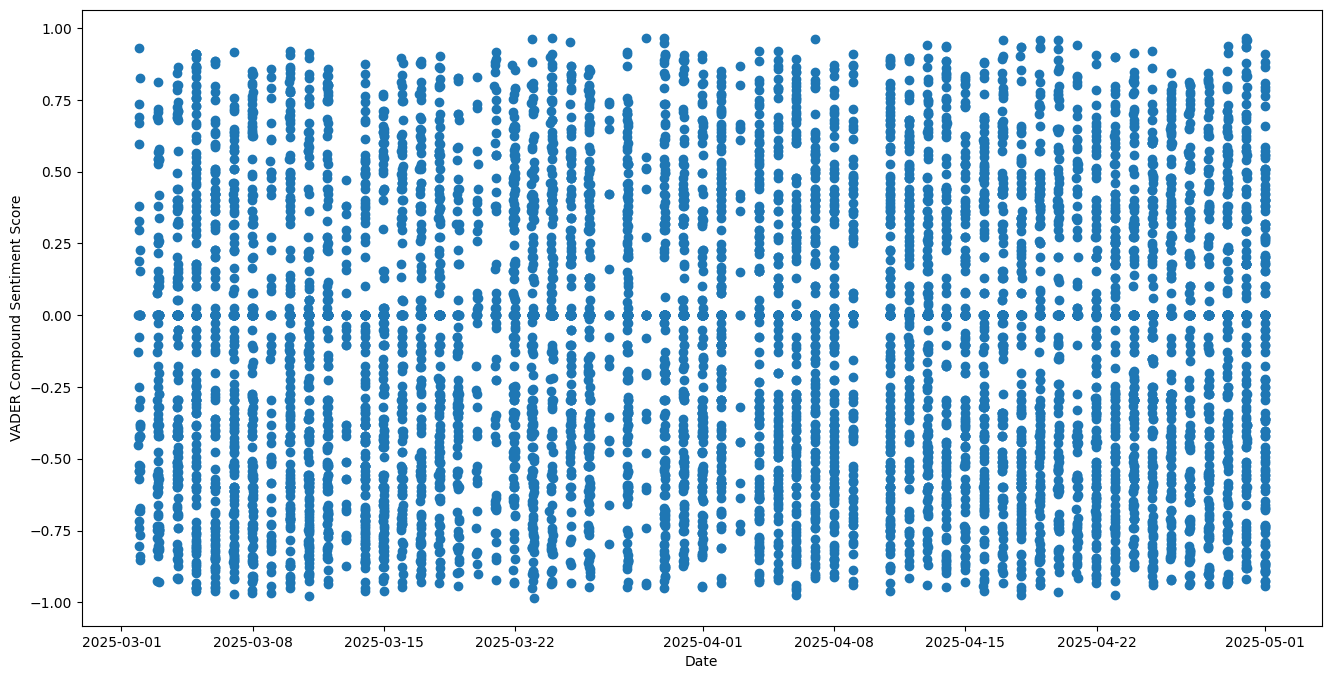

In [20]:
plt.figure(figsize=(16, 8))
plt.scatter(combined_df.index, combined_df['vader_compound'])
plt.xlabel('Date')
plt.ylabel('VADER Compound Sentiment Score')

In [21]:
combined_df=combined_df.sort_index()

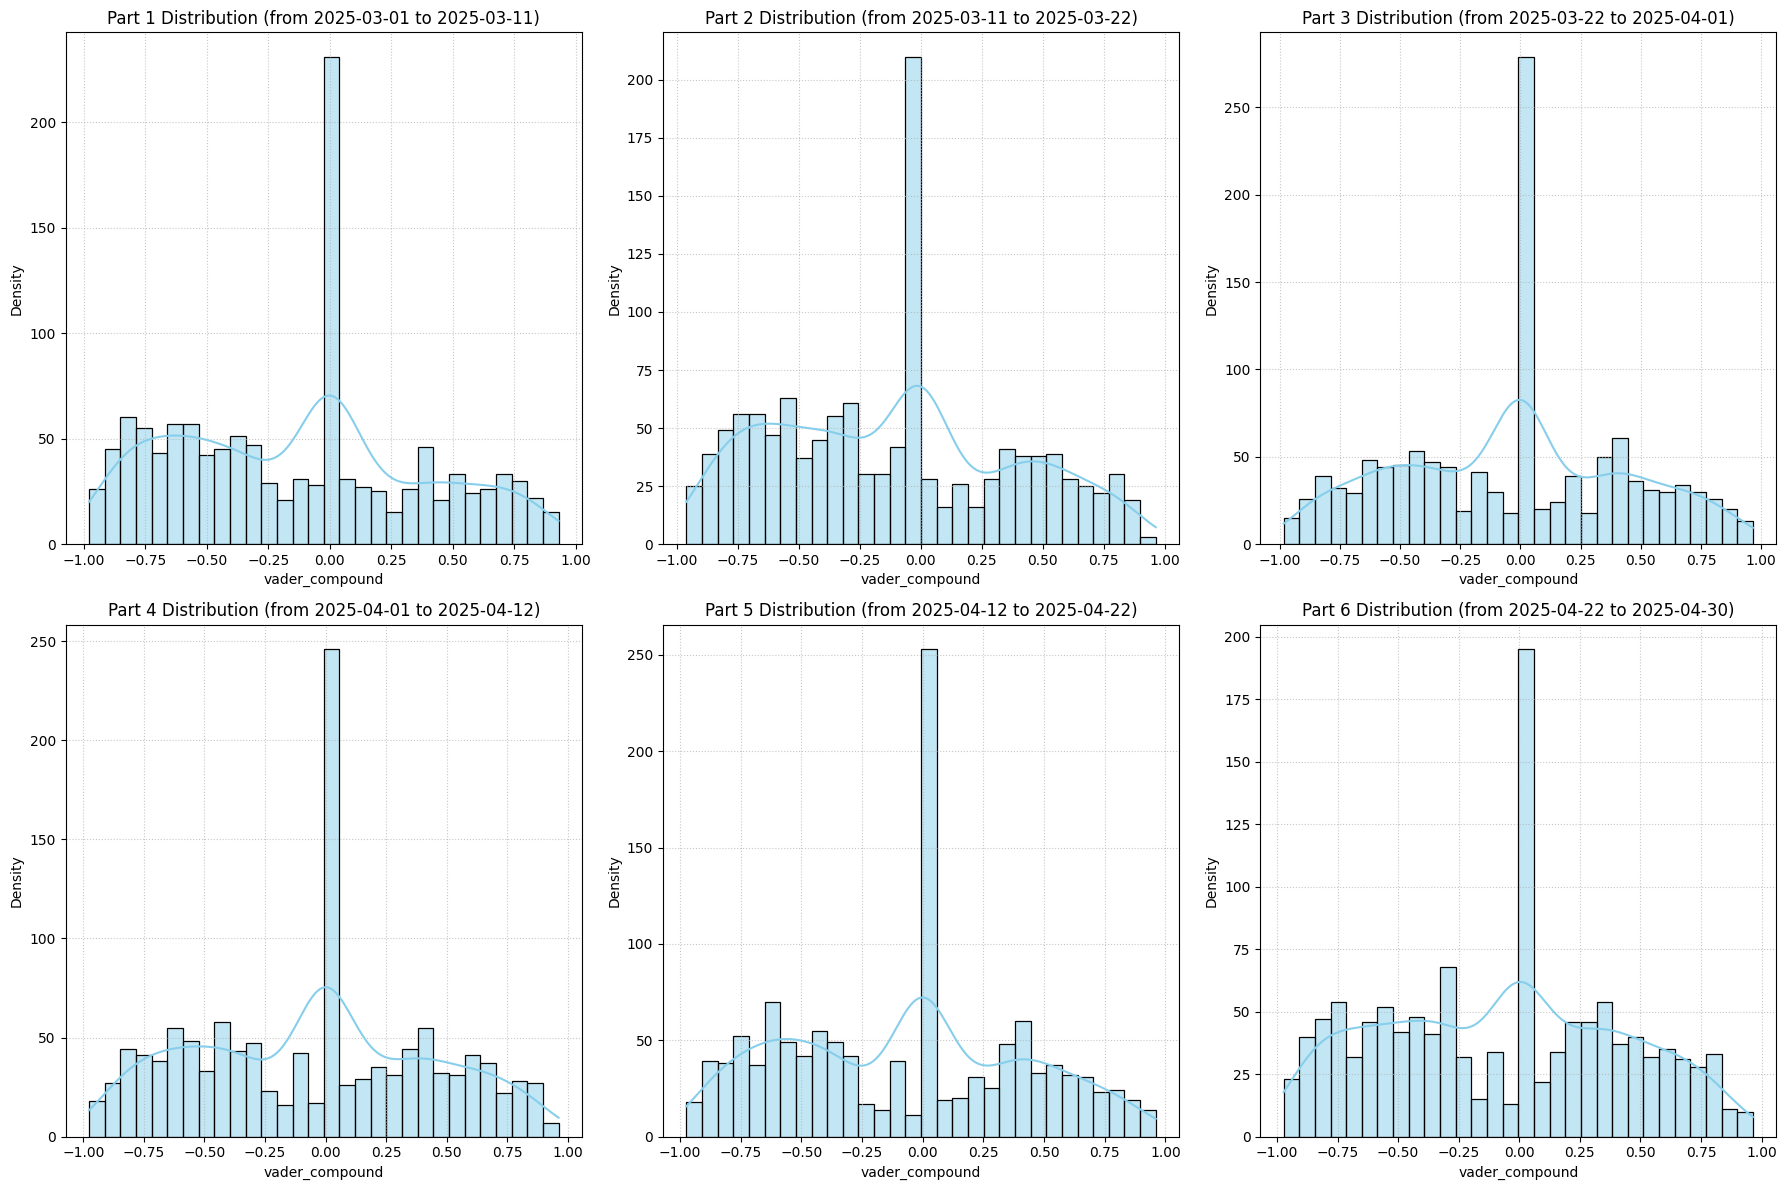

In [22]:
num_parts = 6
list_of_dfs = np.array_split(combined_df, num_parts)
# for data in list_of_dfs:
#     sns.histplot(data, kde=True, bins=30, color='skyblue')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12)) # (rows, cols)
axes = axes.flatten() # 將 axes 陣列扁平化，方便通過索引遍歷

for i, data_part in enumerate(list_of_dfs):
    ax = axes[i] # 獲取當前迴圈的子圖區域

    # 繪製直方圖到指定的子圖上
    sns.histplot(data_part['vader_compound'], kde=True, bins=30, color='skyblue', ax=ax)

    # 添加子圖標題
    ax.set_title(f'Part {i+1} Distribution (from {data_part.index.min().strftime("%Y-%m-%d")} to {data_part.index.max().strftime("%Y-%m-%d")})')
    ax.set_xlabel('vader_compound')
    ax.set_ylabel('Density')
    ax.grid(True, linestyle=':', alpha=0.7) # 添加網格線

# 調整佈局，避免標題和標籤重疊
plt.tight_layout()
plt.show()

In [23]:
combined_df_canada = combined_df[combined_df['Tweet Content'].str.contains('Canada|Canadian', case=False, na=False)]

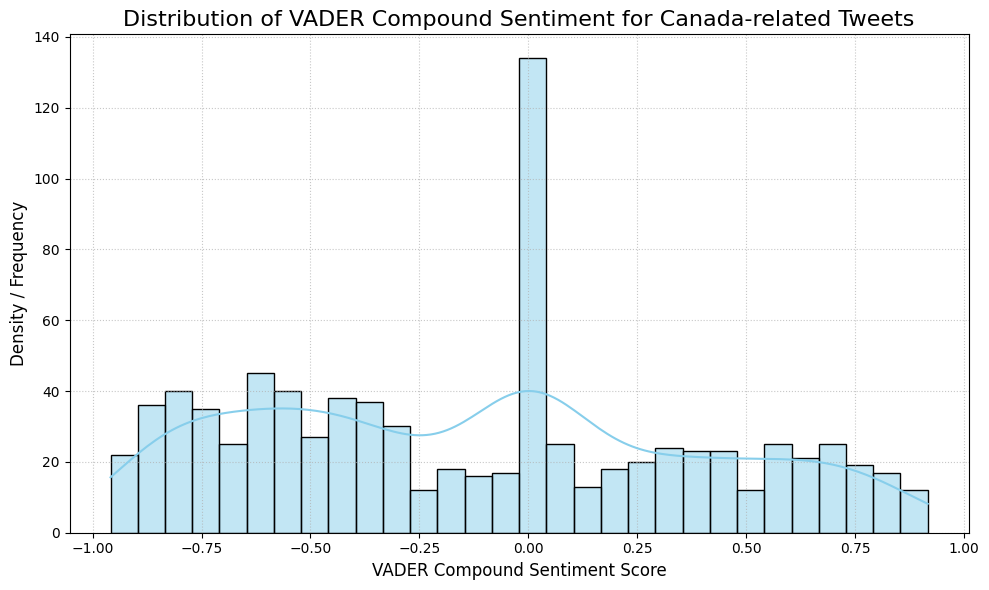

In [24]:
plt.figure(figsize=(10, 6)) # 設定圖形大小

sns.histplot(combined_df_canada['vader_compound'], kde=True, bins=30, color='skyblue')

# 加標題
plt.title('Distribution of VADER Compound Sentiment for Canada-related Tweets', fontsize=16)

# 加 X 軸標籤
plt.xlabel('VADER Compound Sentiment Score', fontsize=12)

# 加 Y 軸標籤
plt.ylabel('Density / Frequency', fontsize=12)

# 加網格線 (可選，但有助於閱讀)
plt.grid(True, linestyle=':', alpha=0.7)

# 加圖例 (如果有多條曲線，但這裡只有一個直方圖，通常不需要)
# plt.legend() # 如果有 label='...'，可以使用

# 調整佈局，確保所有元素都能顯示且不重疊
plt.tight_layout()

# 顯示圖表
plt.show()

## Clustering Model

In [26]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer

In [27]:
# --- 1. 合併所有推文資料 ---
csv_files = sorted(glob.glob("data/tariff_data_en/*.csv"))
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)
df.head()

,Timestamp,Tweet Content,sentiment
0,2025-03-01T22:17:49.000Z,"Proposed tariffs on China, Canada, and Mexico ...",positive
1,2025-03-01T22:27:25.000Z,President Trump says his 25-percent tariff on ...,positive
2,2025-03-01T23:00:01.000Z,"""You should pay less for someone that has tari...",negative
3,2025-03-01T23:00:01.000Z,"""You should pay less for someone that has tari...",negative
4,2025-03-01T22:30:20.000Z,Beer Companies Say Trump’s Aluminum Tariff Wil...,negative


In [28]:
# --- 2. 標準化欄位與時間處理 ---
df.columns = ['Timestamp', 'text', 'sentiment']
df.dropna(subset=['text'], inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # 含 UTC 時區
event_date = pd.to_datetime("2025-04-02").tz_localize("UTC")
df['period'] = df['Timestamp'].apply(lambda x: 'before' if x < event_date else 'after')

In [29]:
# --- 3. 使用預訓練 Sentence-BERT 將推文轉成語意向量 ---
model = SentenceTransformer('all-MiniLM-L6-v2')  # 輕量快速
X = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 280/280 [00:17<00:00, 15.85it/s]


In [30]:
# --- 4. KMeans 聚類 ---
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
# --- 5. PCA 降維 + 畫群體分布圖 ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

os.makedirs("saved_imgs", exist_ok=True)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.title("KMeans with SBERT Embedding (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')
plt.savefig("saved_imgs/kmeans_pca_sbert.png")
plt.close()

In [32]:
# --- 6. 產出每個群的 WordCloud（照舊）---
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stopwords = set(['tariff', 'trump'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

def plot_cluster_wordcloud(df, cluster_num):
    text = " ".join(df[df['cluster'] == cluster_num]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster_num} WordCloud")
    plt.savefig(f"saved_imgs/cluster_{cluster_num}_wordcloud_sbert.png")
    plt.close()

for cl in sorted(df['cluster'].unique()):
    plot_cluster_wordcloud(df, cl)

### 🧠 群體語意總覽分析

本研究以 Sentence-BERT 模型將推文轉換為語意向量，並透過 KMeans 聚類方法將語料分為六個主題群。經由每群高頻詞彙的詞雲（word cloud）視覺化與語意對照分析後，歸納出各群的核心語境與主題如下：

- **Cluster 0 – 美加貿易爭端與加拿大觀點**  
  該群體聚焦於加拿大與美國之間的貿易關係，頻繁出現的詞彙包含 `Canada`, `Trudeau`, `threat`, `tariffs`，顯示該群多為對美方政策持批評態度的推文，語氣偏向防禦與不滿。

- **Cluster 1 – 市場波動與投資反應**  
  此群包含大量與金融市場相關語彙，如 `market`, `stock`, `investor`, `recession`，反映出用戶對於貿易政策可能對經濟與股市造成影響的擔憂與分析，語氣呈現理性但偏焦慮。

- **Cluster 2 – 中美貿易戰與國際談判**  
  詞彙如 `China`, `export`, `deal`, `war` 明確指出該群主題為中美貿易衝突與談判進展，語氣多帶有對抗性或批判性，且事件後大量湧現，為本研究中最受事件影響的群體。

- **Cluster 3 – 關稅影響與消費經濟**  
  該群多出現 `cost`, `import`, `consumer`, `price`，代表對關稅政策對商品價格與消費者負擔的關注。語氣較為理性、經濟分析導向，屬於討論型內容。

- **Cluster 4 – 政策評論與官方言論反應**  
  含有 `President`, `policy`, `economy`, `administration` 等詞彙，代表該群集中在政府官員與政策制定者的發言評論，語氣可能因政治立場不同而分化，整體呈現評論性與新聞轉述性質。

- **Cluster 5 – 網民輿論與口語表態**  
  本群聚焦於網路社群中的一般輿論，詞彙如 `just`, `say`, `like`, `want` 表現出明顯的非正式、情緒化用語，語氣較為自由、多樣，並包含支持、諷刺與戲謔等多元觀點，是情緒最偏向正面的群體。

整體而言，分群結果有效劃分了不同語意主題，並揭示了政策事件如何在語意與情緒層面觸發特定群體的反應，為理解社群輿


### 📋 群體語意總覽表格

| Cluster | 主題焦點                         | 高頻關鍵詞（部分）                           | 語氣傾向         | 備註                             |
|---------|----------------------------------|----------------------------------------------|------------------|----------------------------------|
| 0       | 美加貿易爭端與加拿大觀點         | Canada, Trudeau, threat, tariffs, US         | 負面、批判       | 舊議題為主，事件前集中出現       |
| 1       | 市場波動與投資反應               | market, stock, investor, recession, risk     | 焦慮、理性       | 與金融市場連動，反應全球不安     |
| 2       | 中美貿易戰與國際談判             | China, deal, war, export, negotiation        | 對立、憤怒       | 事件後激增，情緒最負面           |
| 3       | 關稅影響與消費經濟               | cost, import, consumer, price, impact        | 中性、理性       | 關注稅收與價格影響               |
| 4       | 政策評論與官方言論反應           | President, policy, administration, economy   | 評論、兩極       | 涉及領導人與政府發言             |
| 5       | 網民輿論與口語表態               | just, like, say, want, week, new             | 多元、偏正向     | 社群用語多，情緒最活躍           |


In [33]:
# --- 7. 額外分析輸出：事件前後各群數量與情緒分布 ---
print("\n📊 各群情緒比例（row-normalized）:")
print(df.groupby('cluster')['sentiment'].value_counts(normalize=True).unstack().fillna(0))

print("\n📆 各群在事件前/後的比例（row-normalized）:")
print(pd.crosstab(df['cluster'], df['period'], normalize='index'))


📊 各群情緒比例（row-normalized）:
sentiment  negative   neutral  positive
cluster                                
0          0.501894  0.174242  0.323864
1          0.536533  0.127507  0.335960
2          0.549412  0.164706  0.285882
3          0.380933  0.251810  0.367257
4          0.504292  0.194421  0.301288
5          0.425767  0.164417  0.409816

📆 各群在事件前/後的比例（row-normalized）:
period      after    before
cluster                    
0        0.089015  0.910985
1        0.393266  0.606734
2        0.755294  0.244706
3        0.446903  0.553097
4        0.443348  0.556652
5        0.461350  0.538650


## 分群情緒傾向與事件前後分布分析

為探討推文內容在語意與情緒上的異質性，我們使用 Sentence-BERT 嵌入向量與 KMeans 聚類對語料進行分群（共六群），並進一步分析各群的情緒比例及其在關稅政策事件（2025 年 4 月 2 日）前後的出現頻率。下列為各群重點分析結果：

1. 情緒傾向分析
透過原始資料中的情緒標註（positive、neutral、negative），我們計算了各群體內部的情緒分布。結果顯示，群 0、1、2 的負面情緒比例皆超過 50%，反映其內容多涉及爭議性話題或批判性語言。特別是群 2，負面情緒高達 54.9%，其主題以中美貿易戰為主，詞彙如 "Chinese", "war", "export", "negotiation" 明顯帶有強烈對立語意。

相較之下，群 3 與群 5 呈現相對中性或偏向正向情緒，其中群 5 的正向情緒比例最高（約 40.9%），顯示該群文本多以網民口語評論為主，語氣較為自由且表達支持、讚許等情緒的比例較高。群 3 則多與消費者成本、進口商品相關，語氣相對理性與分散。

2. 事件前後出現比例分析
對於事件時間（2025-04-02）前後的分布，我們發現各群反應明顯不同。群 2 的推文有超過 75% 發生於事件之後，顯示該主題與該事件（如新一輪關稅政策、重大外交爭端）有高度相關性，並引發大量後續討論。相對而言，群 0 的推文 91% 發生在事件之前，推測與早期美加貿易爭端相關的議題熱度已逐漸退燒。

其他群（群 1、3、4、5）則呈現出較為平均的分布，顯示這些主題在事件前後均有持續性討論。例如群 1（市場波動與投資）、群 4（政府政策與總統發言）皆為長期關注議題，並非僅由特定事件引發。

3. 總結
綜合語意與時間分析可知，本次事件最直接影響的群體為 Cluster 2，其不僅情緒傾向偏負面，亦在事件後大量增加。此結果突顯語意分群能有效區分出對政策事件敏感的主題群，為輿情變化監控與情緒預測提供依據。未來可考慮進一步追蹤此類事件引發的次波輿論走向，並結合情緒強度與主題動態模型以強化分析深度。



## 0404 (美股重挫)

In [36]:
# --- 1. 合併所有推文資料 ---
csv_files = sorted(glob.glob("data/tariff_data_en/*.csv"))
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)
df.head()

,Timestamp,Tweet Content,sentiment
0,2025-03-01T22:17:49.000Z,"Proposed tariffs on China, Canada, and Mexico ...",positive
1,2025-03-01T22:27:25.000Z,President Trump says his 25-percent tariff on ...,positive
2,2025-03-01T23:00:01.000Z,"""You should pay less for someone that has tari...",negative
3,2025-03-01T23:00:01.000Z,"""You should pay less for someone that has tari...",negative
4,2025-03-01T22:30:20.000Z,Beer Companies Say Trump’s Aluminum Tariff Wil...,negative


In [37]:
# --- 2. 標準化欄位與時間處理 ---
df.columns = ['Timestamp', 'text', 'sentiment']
df.dropna(subset=['text'], inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # 含 UTC 時區
event_date = pd.to_datetime("2025-04-04").tz_localize("UTC")
df['period'] = df['Timestamp'].apply(lambda x: 'before' if x < event_date else 'after')

In [38]:
# --- 3. 使用預訓練 Sentence-BERT 將推文轉成語意向量 ---
model = SentenceTransformer('all-MiniLM-L6-v2')  # 輕量快速
X = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 280/280 [00:13<00:00, 21.36it/s]


In [39]:
# --- 4. KMeans 聚類 ---
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [40]:
# --- 5. PCA 降維 + 畫群體分布圖 ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

os.makedirs("saved_imgs_0404", exist_ok=True)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.title("KMeans with SBERT Embedding (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')
plt.savefig("saved_imgs_0404/kmeans_pca_sbert.png")
plt.close()

In [41]:
# --- 6. 產出每個群的 WordCloud（照舊）---
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stopwords = set(['tariff', 'trump','stock'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

def plot_cluster_wordcloud(df, cluster_num):
    text = " ".join(df[df['cluster'] == cluster_num]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster_num} WordCloud")
    plt.savefig(f"saved_imgs_0404/cluster_{cluster_num}_wordcloud_sbert.png")
    plt.close()

for cl in sorted(df['cluster'].unique()):
    plot_cluster_wordcloud(df, cl)

In [42]:
# --- 7. 額外分析輸出：事件前後各群數量與情緒分布 ---
print("\n📊 各群情緒比例（row-normalized）:")
print(df.groupby('cluster')['sentiment'].value_counts(normalize=True).unstack().fillna(0))

print("\n📆 各群在事件前/後的比例（row-normalized）:")
print(pd.crosstab(df['cluster'], df['period'], normalize='index'))


📊 各群情緒比例（row-normalized）:
sentiment  negative   neutral  positive
cluster                                
0          0.501894  0.174242  0.323864
1          0.536533  0.127507  0.335960
2          0.549412  0.164706  0.285882
3          0.380933  0.251810  0.367257
4          0.504292  0.194421  0.301288
5          0.425767  0.164417  0.409816

📆 各群在事件前/後的比例（row-normalized）:
period      after    before
cluster                    
0        0.087121  0.912879
1        0.376074  0.623926
2        0.749412  0.250588
3        0.417136  0.582864
4        0.419742  0.580258
5        0.446626  0.553374


### 🌟 亮點觀察總結（事件為 4/4 股市暴跌）

- **Cluster 2：事件後激增，反映中美貿易與股市連動恐慌**  
  該群以 `China`, `war`, `tariffs`, `deal`, `talk` 為核心詞彙，聚焦中美衝突與政策交鋒。  
  有 **74.9% 推文出現在事件後**，且 **負面情緒高達 54.9%**，是對 4/4 市場衝擊反應最直接的一群。

- **Cluster 0：以加拿大視角討論貿易政策，歷史成分較高**  
  關鍵詞如 `Canada`, `Trudeau`, `threat`, `tariffs`, `American` 指出其焦點在加美貿易爭端，  
  **91.3% 發表於事件前**，顯示此為早期議題，與 4/4 股災相關性不高。

- **Cluster 1：投資人觀點顯著，展現市場憂慮與波動預期**  
  以 `market`, `stock`, `investor`, `recession`, `Bitcoin` 等詞為主，語氣偏焦慮。  
  **37.6% 推文來自事件後**，且 **負面情緒為 53.7%**，反映金融市場對利空消息高度敏感。

- **Cluster 3：價格與消費層面討論，具經濟理性分析特徵**  
  詞彙如 `price`, `cost`, `consumer`, `import`, `pay`，語氣較中性、分析導向。  
  雖 **41.7% 為事件後貼文**，但其負面情緒比例僅為 38.1%，屬於情緒較平衡的群體。

- **Cluster 4：集中政府言論與宏觀政策評論，語氣偏政治性**  
  高頻詞如 `President`, `plan`, `policy`, `economy`, `Donald`，反映政治領導與經濟戰略討論。  
  約 **42% 推文為事件後**，負面情緒也達 **50.4%**，代表政經議題在股災後仍具討論熱度。

- **Cluster 5：社群語言活躍，口語化與情緒波動明顯**  
  使用 `just`, `war`, `day`, `like`, `President`, `threat` 等詞彙，帶有即時評論與網民語感。  
  為正面情緒最高群（**40.9%**），**44.7% 為事件後貼文**，可能包含幽默、戲謔或支持發言。


#### Stock market related

In [43]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Step 1：篩選事件當天的推文
event_date = pd.to_datetime("2025-04-04").tz_localize("UTC")
same_day_df = df[df['Timestamp'].dt.date == event_date.date()]

# Step 2：使用 CountVectorizer 抽取單字頻率
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_count = vectorizer.fit_transform(same_day_df['text'])

# Step 3：統計最常出現的詞
word_counts = X_count.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()
top_words = pd.DataFrame({'word': vocab, 'count': word_counts})
top_words = top_words.sort_values(by='count', ascending=False).head(30)

# Step 4：可視化（選擇性）
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(top_words['word'][::-1], top_words['count'][::-1])
plt.title("🔍 Top Keywords on 2025-04-04 (Stock Plunge Day)")
plt.xlabel("Frequency")
plt.tight_layout()
plt.savefig("saved_imgs_0404/event_day_top_words.png")
plt.close()


## 0409 (額外關稅第一波施加)


In [44]:
# --- 1. 合併所有推文資料 ---
csv_files = sorted(glob.glob("data/tariff_data_en/*.csv"))
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)
df.head()

,Timestamp,Tweet Content,sentiment
0,2025-03-01T22:17:49.000Z,"Proposed tariffs on China, Canada, and Mexico ...",positive
1,2025-03-01T22:27:25.000Z,President Trump says his 25-percent tariff on ...,positive
2,2025-03-01T23:00:01.000Z,"""You should pay less for someone that has tari...",negative
3,2025-03-01T23:00:01.000Z,"""You should pay less for someone that has tari...",negative
4,2025-03-01T22:30:20.000Z,Beer Companies Say Trump’s Aluminum Tariff Wil...,negative


In [45]:
# --- 2. 標準化欄位與時間處理 ---
df.columns = ['Timestamp', 'text', 'sentiment']
df.dropna(subset=['text'], inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # 含 UTC 時區
event_date = pd.to_datetime("2025-04-09").tz_localize("UTC")
df['period'] = df['Timestamp'].apply(lambda x: 'before' if x < event_date else 'after')

In [46]:
# --- 3. 使用預訓練 Sentence-BERT 將推文轉成語意向量 ---
model = SentenceTransformer('all-MiniLM-L6-v2')  # 輕量快速
X = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 280/280 [00:13<00:00, 21.22it/s]


In [47]:
# --- 4. KMeans 聚類 ---
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [48]:
# --- 5. PCA 降維 + 畫群體分布圖 ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

os.makedirs("saved_imgs_0409", exist_ok=True)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='tab10', alpha=0.6)
plt.title("KMeans with SBERT Embedding (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')
plt.savefig("saved_imgs_0409/kmeans_pca_sbert.png")
plt.close()

In [49]:
# --- 6. 產出每個群的 WordCloud（照舊）---
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
custom_stopwords = set(['tariff', 'trump'])
all_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

def plot_cluster_wordcloud(df, cluster_num):
    text = " ".join(df[df['cluster'] == cluster_num]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster_num} WordCloud")
    plt.savefig(f"saved_imgs_0409/cluster_{cluster_num}_wordcloud_sbert.png")
    plt.close()

for cl in sorted(df['cluster'].unique()):
    plot_cluster_wordcloud(df, cl)

In [50]:
# --- 7. 額外分析輸出：事件前後各群數量與情緒分布 ---
print("\n📊 各群情緒比例（row-normalized）:")
print(df.groupby('cluster')['sentiment'].value_counts(normalize=True).unstack().fillna(0))

print("\n📆 各群在事件前/後的比例（row-normalized）:")
print(pd.crosstab(df['cluster'], df['period'], normalize='index'))


📊 各群情緒比例（row-normalized）:
sentiment  negative   neutral  positive
cluster                                
0          0.501894  0.174242  0.323864
1          0.536533  0.127507  0.335960
2          0.549412  0.164706  0.285882
3          0.380933  0.251810  0.367257
4          0.504292  0.194421  0.301288
5          0.425767  0.164417  0.409816

📆 各群在事件前/後的比例（row-normalized）:
period      after    before
cluster                    
0        0.072917  0.927083
1        0.315903  0.684097
2        0.652941  0.347059
3        0.327836  0.672164
4        0.333047  0.666953
5        0.391411  0.608589


### 📋 群體語意總覽表格（整合語意、情緒與時間）

| Cluster | 主題焦點                         | 高頻關鍵詞（部分）                           | 語氣傾向       | 負面情緒比例 | 事件後佔比 | 備註                             |
|---------|----------------------------------|----------------------------------------------|----------------|----------------|------------|----------------------------------|
| 0       | 美加貿易爭端與加拿大觀點         | Canada, Trudeau, threat, tariffs, product    | 批判、防禦型   | 50.2%         | 7.3%       | 幾乎皆在事件前出現，為歷史議題   |
| 1       | 市場波動與投資反應               | stock, market, investor, inflation, Bitcoin  | 焦慮、理性型   | 53.7%         | 31.6%      | 關注股市與金融衝擊               |
| 2       | 中美貿易戰與國際談判             | China, deal, war, export, talk               | 對立、批判型   | 54.9%         | 65.3%      | 與事件高度相關，事件後激增       |
| 3       | 關稅影響與消費經濟               | tariffs, price, cost, consumer, product      | 中性、理性型   | 38.1%         | 32.8%      | 涉及民生物價與進出口稅收         |
| 4       | 政策評論與官方言論反應           | President, economy, policy, plan             | 評論性混合型   | 50.4%         | 33.3%      | 涉及政府發言與政策方向           |
| 5       | 網民輿論與社群口語反應           | just, like, say, new, talk, war              | 多元、情緒化   | 42.6%         | 39.1%      | 社群意見自由發表，情緒波動大     |


### 🌟 亮點觀察總結

- **Cluster 2 是事件後反應最強烈的群體**  
  此群以「中美貿易戰」為核心主題，包含大量如 `China`, `war`, `deal`, `export` 等對立性詞彙。  
  推文中有 **超過 65% 出現在事件後**，且 **負面情緒佔比高達 54.9%**，顯示事件可能引發了大量不安與批判言論。

- **Cluster 0 幾乎全部為事件前的歷史議題**  
  聚焦「美加貿易爭端」與加拿大角度（詞彙如 `Canada`, `Trudeau`, `threat`），  
  **事件後僅佔 7.3%**，說明此主題可能已逐漸降溫，且討論集中於過往政策與影響。

- **Cluster 5 為情緒最正向的群體，語言風格偏社群與口語化**  
  常見詞彙如 `just`, `like`, `say`, `want`，顯示用語自然、輕鬆，符合社交平台特徵。  
  **正向情緒佔比達 40.9%**，為六群之最，呈現輿論自由表達與部分幽默或支持性語氣。

- **Cluster 3 討論焦點偏向經濟負擔與消費者角度**  
  關注如 `cost`, `price`, `consumer`, `impact` 等詞彙，語氣整體偏中性與理性。  
  雖不屬於情緒極端群體，但也具備長期討論價值，反映政策對生活層面的實際影響。

- **Cluster 1 表現出對市場的焦慮與觀望情緒**  
  主題集中於 `stock`, `market`, `investor`, `recession` 等詞，  
  並有 **53.7% 的負面情緒**，顯示經濟不確定性引發的投資憂慮普遍存在。

- **Cluster 4 涉及政府與領導人言論，情緒兩極化**  
  高頻詞包含 `President`, `policy`, `plan`, `economy`，涉及官方發言與政見。  
  雖分布穩定，但情緒容易隨立場變化而分化，呈現評論性與對立性混合語氣。
